# Speech Scrambler — **Decoder**

This notebook implements the **inverse unscrambling** for the band-scrambled speech created by the encoder.

### How to use
1. We are setting 'INPUT_WAV' to the scrambled WAV. This is the encoder output. (default: 'scrambled.wav').
2. Using the **same** `N_BANDS` and **inverse mapping** of what the encoder used.
3. Runing all cells. The reconstructed audio will be saved as **'reconstructed.wav'** with visualizations.


# Speech Band-Scrambler — Decoder: Algorithm Overview

This section explains, in plain words, what the **decoder** code does and how each step fits together.

---

## Inputs & Setup
- **fs**: sample rate of the audio (a.k.a. `sr`).
- **N**: number of equal-width frequency bands (e.g., 7).
- **encoder_order**: the permutation used by the encoder (1-based). We invert it to know where each target band originally came from.

---

## 1) Build an Equal-Band Filterbank
**Functions:** `design_bandpass_fir`, `make_filterbank`

- The frequency range from **0** to **Nyquist (fs/2)** is split into **N** equal bands using `np.linspace`.
- For each band \[f_lo, f_hi\], we design a **linear-phase FIR bandpass** filter:
  - A small **transition width** (`transition_fraction` × band width) pulls the passband edges inward to make a realizable filter.
  - **Kaiser window** parameter **β** is chosen from the requested stopband attenuation (`min_stop_atten_db`).
  - The **number of taps** is estimated from attenuation and transition width, then forced to be **odd** (linear-phase symmetry) and at least **101**.
- Output: a list of `(f_lo, f_hi, taps)` for each band, plus the full array of band edges.

**Why:** The filterbank lets us isolate energy in specific frequency slices cleanly and with predictable phase delay.

---

## 2) Analyze the Scrambled Signal into Bands
**Function:** `analyze_bands`

- The scrambled input signal is passed through **each** bandpass filter using `lfilter`.
- Result: `bands[k]` contains the portion of the scrambled audio that currently lives in **target band k**.

**Why:** The encoder permuted bands; analyzing tells us what’s in each target slot now.

---

## 3) Invert the Encoder’s Permutation
**Function:** `inverse_permutation_from_encoder_order`

- If the encoder mapping is `encoder_order[src] = tgt` (1-based),
  we compute the inverse mapping `inv[tgt] = src`.
- This tells the decoder: **the energy we see in target band `tgt` originally came from source band `src`.**

**Why:** Decoding is the inverse operation; we must know where to move each target band back.

---

## 4) Unscramble (Shift Back and Confine)
**Function:** `unscramble_bands`

For each **target band** index `tgt_idx`:
1. Find the original **source band** index: `src_idx = inv[tgt_idx] - 1`.
2. Compute the **center frequencies** of the target and source bands:
   - `f_tgt_c = (tgt_lo + tgt_hi)/2`
   - `f_src_c = (src_lo + src_hi)/2`
3. Compute the **frequency shift** needed:  
   `delta_f = f_src_c - f_tgt_c`  
   (i.e., shift the observed target band back to the source band’s center).
4. **Real cosine mixing** (heterodyning): multiply the band signal by `2*cos(2π*delta_f*t/fs)` to shift it in frequency.
   - Real mixing creates **two images** (±Δf). The factor **2** compensates the amplitude split.
5. **Confine** with the **source band’s** filter to keep only the desired image inside the source band and suppress the mirror.
6. **Accumulate** the confined result into the output sum.

After processing all bands, the sum `out` is the **reconstructed (decoded)** audio.

**Why:** Shifting each band back to its original center and filtering into the original slot restores the spectral structure.

---

## 5) Visualize (Optional)
**Function:** `plot_wave_and_spectrogram`

- Plots the **waveform** and a **dB spectrogram** (STFT).
- Use it to confirm that, compared to the scrambled plot, energy has returned to the original frequency regions.

---

## Key Design Notes
- **Linear-phase FIR** ⇒ uniform delay across bands, preserving time structure (only a constant latency).
- **Kaiser window** gives a clean tradeoff: higher attenuation → more taps/CPU, better isolation.
- **transition_fraction** controls filter sharpness vs. length; smaller = sharper (longer), larger = gentler (shorter).
- Decoding is exact in principle; any residual artifacts come from finite stopband attenuation and transitions (not from the permutation itself).

---

### TL;DR
- Split spectrum into **N** bands → **analyze** scrambled audio per band → **invert permutation** → **shift each band back** with a cosine mixer → **filter into source band** → **sum** → (optional) **plot**.


In [3]:
import numpy as np
import librosa, librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter

# ---- User settings ----
INPUT_WAV = 'scrambled.wav'   # <- from encoder output
OUTPUT_WAV = 'reconstructed.wav'

# Must match the encoder's configuration
N_BANDS = 7
ENCODER_OUTPUT_ORDER = [7, 5, 3, 1, 2, 4, 6]  # the encoder permutation
MIN_STOP_ATTEN_DB = 40
TRANSITION_FRACTION = 0.12

assert len(ENCODER_OUTPUT_ORDER) == N_BANDS and set(ENCODER_OUTPUT_ORDER) == set(range(1, N_BANDS+1))

In [4]:
def design_bandpass_fir(fs, f_lo, f_hi, min_stop_atten_db=40, transition_fraction=0.12):
    nyq = fs / 2.0
    width_hz = (f_hi - f_lo)
    tw = transition_fraction * width_hz
    f1 = max(0.0, f_lo + tw)
    f2 = min(nyq, f_hi - tw)
    if f2 <= f1:
        f1 = f_lo
        f2 = f_hi
        tw = max(1.0, 0.02*width_hz)
    A = float(min_stop_atten_db)
    if A > 50:
        beta = 0.1102*(A-8.7)
    elif A >= 21:
        beta = 0.5842*(A-21)**0.4 + 0.07886*(A-21)
    else:
        beta = 0.0
    delta_f = max(1e-6, (tw/nyq))
    N_est = int(np.ceil((A - 8.0) / (2.285 * 2*np.pi*delta_f)))
    numtaps = int(max(101, (N_est//2)*2 + 1))
    taps = firwin(numtaps, [f1/nyq, f2/nyq], pass_zero=False, window=('kaiser', beta))
    return taps

def make_filterbank(fs, N, min_stop_db=40, transition_fraction=0.12):
    nyq = fs/2
    band_edges = np.linspace(0.0, nyq, N+1)
    filters = []
    for k in range(N):
        f_lo, f_hi = band_edges[k], band_edges[k+1]
        taps = design_bandpass_fir(fs, f_lo, f_hi, min_stop_db, transition_fraction)
        filters.append((f_lo, f_hi, taps))
    return band_edges, filters

def center_frequency(f_lo, f_hi):
    return 0.5*(f_lo + f_hi)

def analyze_bands(x, filters):
    bands = []
    for f_lo, f_hi, taps in filters:
        bands.append(lfilter(taps, [1.0], x))
    return bands

def inverse_permutation_from_encoder_order(encoder_order):
    # encoder_order[src] = target (1..N)
    # We want inv[target] = src
    N = len(encoder_order)
    inv = [None]*N
    for src in range(N):
        tgt = encoder_order[src] - 1
        inv[tgt] = src + 1
    return inv

def unscramble_bands(bands, band_edges, encoder_order, fs, filters):
    # The encoder moved src->tgt per encoder_order. To invert, shift each observed target band back to its source.
    N = len(bands)
    out = np.zeros_like(bands[0])
    t = np.arange(len(out))
    # inv[tgt] = src (1..N)
    inv = inverse_permutation_from_encoder_order(encoder_order)
    for tgt_idx in range(N):
        src_idx = inv[tgt_idx] - 1
        tgt_lo, tgt_hi = band_edges[tgt_idx], band_edges[tgt_idx+1]
        src_lo, src_hi = band_edges[src_idx], band_edges[src_idx+1]
        f_tgt_c = 0.5*(tgt_lo + tgt_hi)
        f_src_c = 0.5*(src_lo + src_hi)
        delta_f = f_src_c - f_tgt_c  # shift back toward original
        mixer = 2.0*np.cos(2*np.pi*delta_f * t / fs)
        shifted = bands[tgt_idx] * mixer
        src_taps = filters[src_idx][2]
        confined = lfilter(src_taps, [1.0], shifted)
        out += confined
    return out

def plot_wave_and_spectrogram(y, sr, title_prefix):
    plt.figure()
    plt.title(f"{title_prefix} — Waveform")
    plt.plot(np.arange(len(y))/sr, y)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.tight_layout()

    D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
    DB = librosa.amplitude_to_db(D, ref=np.max)
    plt.figure()
    librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='linear')
    plt.title(f"{title_prefix} — Spectrogram (linear freq)")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()


Loaded: scrambled.wav | sr=44100 | duration=14.07s


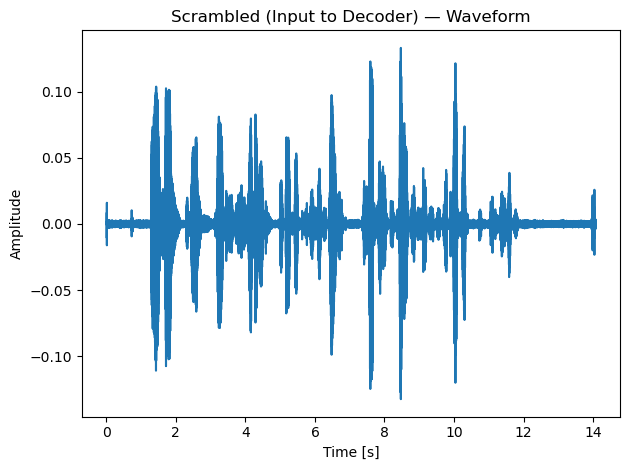

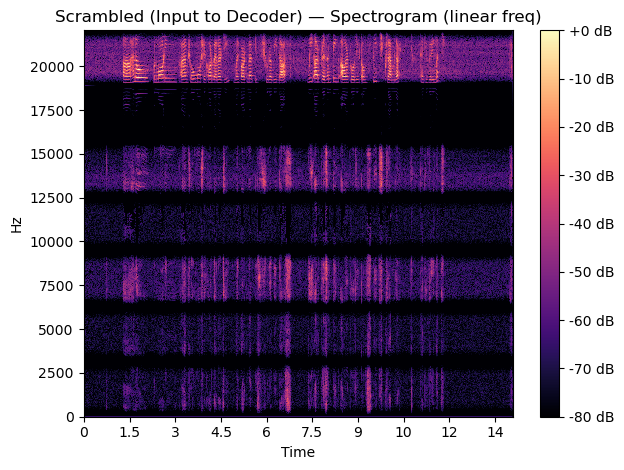

In [9]:
# ---- Load scrambled audio ----
y_scr, sr = librosa.load(INPUT_WAV, sr=None, mono=True)
print(f'Loaded: {INPUT_WAV} | sr={sr} | duration={len(y_scr)/sr:.2f}s')
y_scr = np.asarray(y_scr, dtype=np.float32)
plot_wave_and_spectrogram(y_scr, sr, 'Scrambled (Input to Decoder)')

# Scrambled Input: Waveform & Spectrogram — Explanation

This page explains what you’re seeing in the two plots of the **scrambled (encoded) audio** that is fed to the decoder.

---

## Top plot — *“Scrambled (Input to Decoder) — Waveform”*
- **What it is:** time-domain signal (amplitude vs. seconds) of the scrambled audio.
- **What to notice:**
  - The overall **envelope** (loud/quiet regions and syllable timing) still looks speech-like because scrambling preserves **time structure**.
  - Peaks around the middle (e.g., ~6–9 s) and quieter parts near the beginning/end match where speech activity happens.
  - Amplitude stays within a safe range (no clipping), and the mean is near zero (as expected for audio).

## Bottom plot — *“Scrambled (Input to Decoder) — Spectrogram (linear freq)”*
- **What it is:** frequency content over time (color shows magnitude in dB).
- **What to notice:**
  - You see horizontal **bands** with dark gaps: these are the **filterbank passbands** and **stopbands**.
  - Strong, speech-like patterns show up in **unusual frequency regions** (e.g., up near 18–22 kHz). This reveals that low-frequency speech content was **moved** upward (and other bands re-mapped) by the permutation.
  - Vertical streaks (onsets/consonants) line up in **time** with the waveform peaks; **time is preserved**, but **frequency placement** is scrambled.

---

### Big idea
- **Top plot** answers: “*How loud is the signal over time?*”  
- **Bottom plot** answers: “*Where in frequency is the energy over time?*”  
- Scrambling **keeps the time envelope** but **rearranges the spectrum**, which is why the audio sounds unintelligible until the decoder shifts each band back to its original slot.


# Differences Between the Two Waveforms and Spectrograms

This compares the **Scrambled (Input to Decoder)** vs **Reconstructed (Decoded)** views.

---

## Waveforms (time-domain)

**What stays the same**
- **Timing & rhythm:** syllable locations, pauses, and loud/quiet regions line up in time for both.  
- **Overall level:** both sit in a safe amplitude range (no clipping), near-zero mean.

**What differs**
- **Scrambled:** still speech-like envelope, but the sound is **unintelligible** because its frequency content was relocated.
- **Decoded:** very similar envelope to the original and **intelligible** again.  
- **Minor shape/latency differences:** decoded waveform can look slightly smoother or shifted by a **constant delay** (linear-phase FIR group delay) and tiny amplitude ripples from filtering.

---

## Spectrograms (frequency vs time)

**What stays the same**
- **Time alignment:** vertical events (onsets/consonants) occur at the same times in both plots.
- **Dynamic range display:** same dB scale; brighter = stronger energy.

**What differs**
- **Scrambled:**
  - Clear **horizontal banding** with dark stopbands from the filterbank.
  - **Energy appears in unusual bands** (e.g., strong activity up near 18–22 kHz), proving bands were **permuted**.
  - May show faint “ghosts” from real mixing (±Δf) that are mostly contained by the target filters.

- **Decoded:**
  - **Energy returns to low frequencies** (<~4–5 kHz) where speech naturally lives (formants + pitch harmonics).
  - High-band artifacts seen in the scrambled plot are **greatly reduced or gone**.
  - You might still see faint horizontal traces—the **filterbank imprint**—but the distribution is again **speech-like**.

---

## TL;DR
- **Waveform:** time structure ≈ same for both; decoded sounds normal, scrambled doesn’t.
- **Spectrogram:** frequency placement is **rearranged** in the scrambled plot (striped, energy in wrong bands) and **restored** in the decoded plot (energy back in low bands).


Saved reconstructed audio -> reconstructed.wav


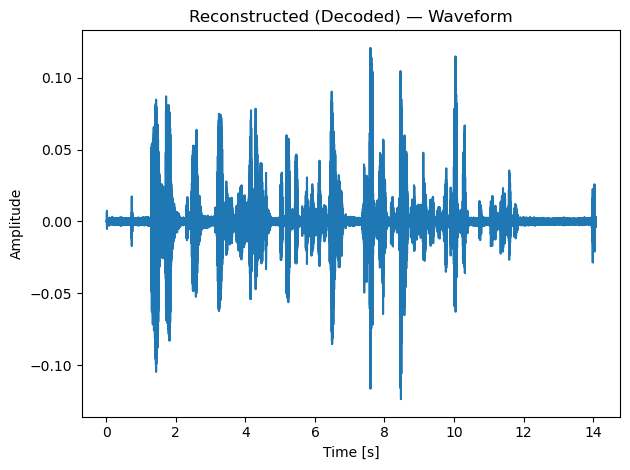

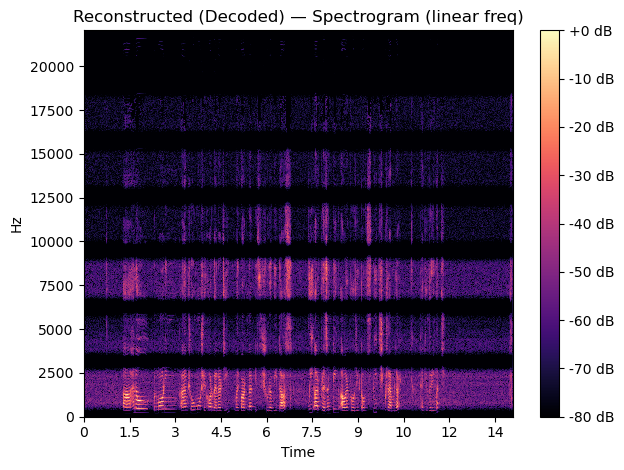

In [11]:
# ---- Build filterbank ----
band_edges, filters = make_filterbank(sr, N_BANDS, MIN_STOP_ATTEN_DB, TRANSITION_FRACTION)
bands = analyze_bands(y_scr, filters)

# ---- Unscramble (decode) ----
y_rec = unscramble_bands(bands, band_edges, ENCODER_OUTPUT_ORDER, sr, filters)
y_rec = np.asarray(y_rec, dtype=np.float32)
sf.write(OUTPUT_WAV, y_rec, sr)
print(f'Saved reconstructed audio -> {OUTPUT_WAV}')
plot_wave_and_spectrogram(y_rec, sr, 'Reconstructed (Decoded)')

# Reconstructed (Decoded): Waveform & Spectrogram — Explanation

This page explains what you’re seeing in the two plots of the **decoded (reconstructed) audio** after the unscrambler has inverted the band permutation.

---

## Top plot — *“Reconstructed (Decoded) — Waveform”*
- **What it is:** time-domain signal (amplitude vs. seconds) of the **decoded** audio.
- **What to notice:**
  - The overall **envelope** (loud/quiet regions and syllable timing) closely matches the **original** recording.
  - Levels stay within a safe range (no clipping), and the mean is near zero (as expected for audio).
  - Tiny shape differences vs. the original can occur due to the **linear-phase FIR** analysis/synthesis (constant group delay) and finite stopband attenuation.

## Bottom plot — *“Reconstructed (Decoded) — Spectrogram (linear freq)”*
- **What it is:** frequency content over time (color shows magnitude in dB) **after** decoding.
- **What to notice:**
  - **Energy returns to low frequencies** (typically < ~4–5 kHz), where speech formants and pitch harmonics live.
  - The strong, unnatural activity seen in high bands in the scrambled spectrogram is **greatly reduced or gone**.
  - You may still see faint horizontal band traces—this is the **filterbank imprint**—but the dominant energy now looks **speech-like**.
  - Vertical onsets (consonants) line up with waveform peaks, confirming **temporal alignment**.

---

### Big idea
- The decoder **shifts each scrambled band back** to its original position and **confines** it with the source band’s filter.  
- **Time structure is preserved**, and **frequency placement is restored**, so the audio becomes **intelligible** again.  
- Any slight coloration or faint residual textures come from practical filter design limits (attenuation and transition bands), not from the permutation itself.


In [13]:
#  Playing the decoded audio in-notebook (no download needed)
# Also exposesing a download link if we want it later.

from IPython.display import Audio, FileLink, display
import os, soundfile as sf

OUTPUT_WAV = 'reconstructed.wav'

# Case 1: y_rec + sr exist -> play from memory and (re)save file
if 'y_rec' in globals() and 'sr' in globals():
    display(Audio(y_rec, rate=sr))           # in-notebook audio player
    try:
        sf.write(OUTPUT_WAV, y_rec, sr)      # save/update file for convenience
    except Exception as e:
        print("Save skipped:", e)

# Case 2: fallback -> play from file if it already exists
elif os.path.exists(OUTPUT_WAV):
    display(Audio(OUTPUT_WAV))

# Otherwise, instruct user to run the decode step first
else:
    print("Decoded audio not found. Run the cell that creates y_rec (unscramble) first.")

# Optional: clickable download link (if file exists)
if os.path.exists(OUTPUT_WAV):
    display(FileLink(OUTPUT_WAV))


C:\Users\HP\reconstructed.wav

# Conclusion

- We successfully **scrambled** the speech by splitting the spectrum into **N bands** and **permuting** them with cosine mixing + bandpass confinement.  
- The **scrambled** waveform keeps the **timing/envelope** of speech but its spectrogram shows **energy in wrong frequency bands** (striped look), making it **unintelligible**.
- The **decoder** inverted the permutation and frequency shifts; after reconstruction, the spectrogram shows **energy back in low bands (<~4–5 kHz)** and the audio becomes **intelligible** again.
- Minor differences vs. the original (faint band traces, slight timbral change, constant delay) are due to **finite stopband attenuation**, **transition bands**, and **linear-phase FIR** delay—not the permutation.

**What this shows**
- Scrambling primarily disrupts **frequency placement** while preserving **time structure**.  
- Decoding restores the original spectral structure with small, expected filtering artifacts.

**Next steps (optional)**
- Try other **N** and **permutations** (e.g., derangements, time-varying keys).  
- Increase attenuation (e.g., 60 dB) for cleaner bands at the cost of longer filters/CPU.  
- Evaluate SNR/Intelligibility objectively (e.g., PESQ/STOI) if needed.
